In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input

In [2]:
datagen = ImageDataGenerator(validation_split = 0.2,
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)


train_generator = datagen.flow_from_directory(
    '/kaggle/input/car-angle-classification-dataset/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)
test_generator = datagen.flow_from_directory(
    '/kaggle/input/car-angle-classification-dataset/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
    
)
print(train_generator.class_indices)

Found 21636 images belonging to 8 classes.
Found 5406 images belonging to 8 classes.
{'0': 0, '130': 1, '180': 2, '230': 3, '270': 4, '320': 5, '40': 6, '90': 7}


In [3]:

weights_path = '/kaggle/input/mobilevnet/keras/default/1/mobilenet_1_0_224_tf_no_top.h5'

base_model = MobileNet(weights=weights_path, include_top=False, input_shape=(224, 224, 3), alpha=1.0)

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)  # 8 car angle classes


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import os


checkpoint_dir = '/kaggle/working/model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras'),  
    monitor='val_accuracy', 
    save_best_only=True, 
    save_weights_only=False,  
    mode='max',
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True,
    verbose=1
)


tensorboard_callback = TensorBoard(
    log_dir='/kaggle/working/logs', 
    histogram_freq=1, 
    write_graph=True,
    write_images=False 
)



In [5]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    


model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples //test_generator.batch_size,
    epochs=15,
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback],
    shuffle=True
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728540852.909483      80 service.cc:145] XLA service 0x7d7e140040c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728540852.909564      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728540857.836009      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/676 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7452 - loss: 0.8509

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.92020, saving model to /kaggle/working/model_checkpoints/model_epoch_01_val_acc_0.92.keras
676/676 ━━━━━━━━━━━━━━━━━━━━ 401s 576ms/step - accuracy: 0.7454 - loss: 0.8500 - val_accuracy: 0.9202 - val_loss: 0.2574
Epoch 2/15
  1/676 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.9062 - loss: 0.4415

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.92020
676/676 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9062 - loss: 0.4415 - val_accuracy: 0.8667 - val_loss: 0.4039
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8869 - loss: 0.3550
Epoch 3: val_accuracy improved from 0.92020 to 0.92429, saving model to /kaggle/working/model_checkpoints/model_epoch_03_val_acc_0.92.keras
676/676 ━━━━━━━━━━━━━━━━━━━━ 328s 481ms/step - accuracy: 0.8869 - loss: 0.3550 - val_accuracy: 0.9243 - val_loss: 0.2492
Epoch 4/15
  1/676 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.9375 - loss: 0.1491
Epoch 4: val_accuracy improved from 0.92429 to 0.93333, saving model to /kaggle/working/model_checkpoints/model_epoch_04_val_acc_0.93.keras
676/676 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9375 - loss: 0.1491 - val_accuracy: 0.9333 - val_loss: 0.1572
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9058 - loss: 0.3012
Epoch 5: val_accuracy did not improve from 0.9333

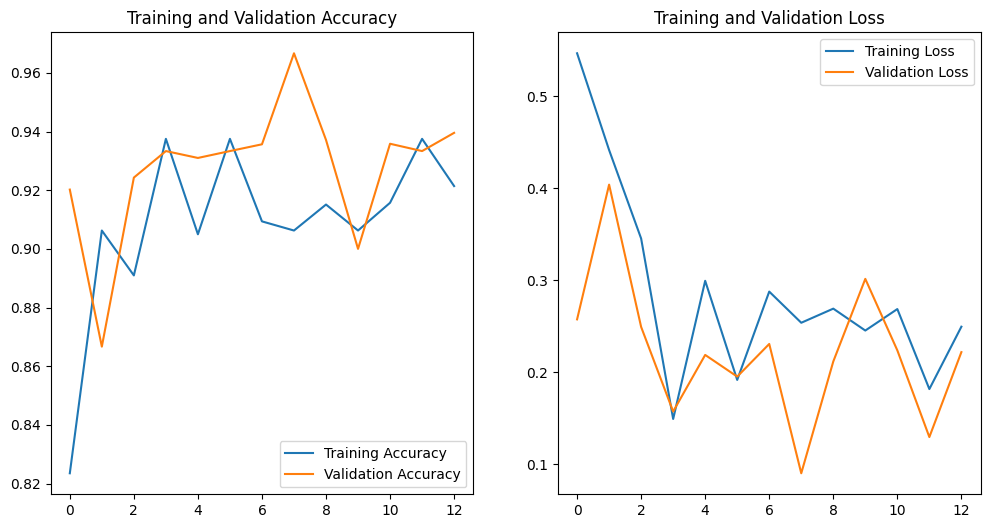

In [7]:
import matplotlib.pyplot as plt


def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()


plot_accuracy_and_loss(history)

169/169 ━━━━━━━━━━━━━━━━━━━━ 69s 398ms/step


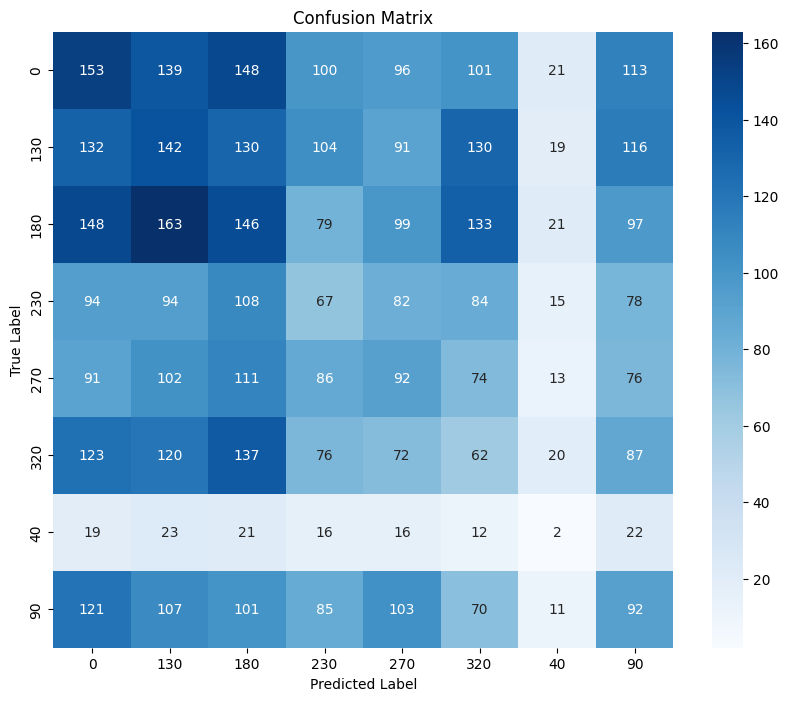

Classification Report
              precision    recall  f1-score   support

           0       0.17      0.18      0.17       871
         130       0.16      0.16      0.16       864
         180       0.16      0.16      0.16       886
         230       0.11      0.11      0.11       622
         270       0.14      0.14      0.14       645
         320       0.09      0.09      0.09       697
          40       0.02      0.02      0.02       131
          90       0.14      0.13      0.13       690

    accuracy                           0.14      5406
   macro avg       0.12      0.12      0.12      5406
weighted avg       0.14      0.14      0.14      5406



In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
true_labels = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(true_labels, y_pred, target_names=target_names))